## Diabetes re-admission Capstone Project 

### Background 

#### The Data

https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008 

10 years clinical care data from 1999-2008
130 hospitals 
101,766 observations and 50 features 
Extracted data 
The record was an inpatient encounter (a hospital admission).
Diabetes was entered into the system as a diagnosis.
50 features 
The length of stay was >= 1 day and <= 14 days
Demographics – race, age, admission type
Medical specialty 
Laboratory tests were performed during the encounter: number of lab tests performed, HbA1C
Medications were administered during the encounter: number of medications, diabetic medications 
Number of outpatient, inpatient, emergency visits in the year before hospitalization 
Diagnosis 

Observations are diabetic patients encounters in hospital 
Missing values, numerical and categorical features
Many numerical features are encoded values
Target variable is categorical 
Dataset is imbalanced with minority of class of 10,000 re-admitted patients 


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import zscore 
import random
import warnings
#warnings.filterwarnings('ignore')

In [2]:
diab_df = pd.read_csv('diabetic_data.csv') 
icd9 = pd.read_csv('output.csv')

In [3]:
##Remove weight column as mostly unknown 
diab_df = diab_df.drop(columns=['weight', 'encounter_id', 'patient_nbr'])

In [4]:
pd.set_option('display.max_columns', 50)
diab_df.shape

(101766, 47)

In [5]:
print(diab_df.info())
print(diab_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   payer_code                101766 non-null  object
 8   medical_specialty         101766 non-null  object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 
 14  numb

In [6]:
##What kind of columns do we have
numer_columns = diab_df.select_dtypes(include=['float64', 'int64']).columns
print(numer_columns)
print("numerical features : " + str(len(numer_columns)))

catag_columns = diab_df.select_dtypes(['object']).columns
print(catag_columns)

Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')
numerical features : 11
Index(['race', 'gender', 'age', 'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [7]:
diab_df.head(10)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,Caucasian,Male,[50-60),2,1,2,3,?,?,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
6,Caucasian,Male,[60-70),3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,Caucasian,Male,[70-80),1,1,7,5,?,?,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30
8,Caucasian,Female,[80-90),2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,Caucasian,Female,[90-100),3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [8]:
icd9.head(10)

,icd9code,long_description,short_description
0,1,Cholera due to vibrio cholerae,Cholera d/t vib cholerae
1,1.1,Cholera due to vibrio cholerae el tor,Cholera d/t vib el tor
2,1.9,Cholera - unspecified,Cholera NOS
3,2,Typhoid fever,Typhoid fever
4,2.1,Paratyphoid fever A,Paratyphoid fever a
5,2.2,Paratyphoid fever B,Paratyphoid fever b
6,2.3,Paratyphoid fever C,Paratyphoid fever c
7,2.9,Paratyphoid fever - unspecified,Paratyphoid fever NOS
8,3,Salmonella gastroenteritis,Salmonella enteritis
9,3.1,Salmonella septicemia,Salmonella septicemia


In [9]:
# # for each column
# for c in list(diab_df.columns):
    
#     # get a list of unique values
#     n = df[c].unique()
    
#     # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
#     if len(n)<30:
#         print(c)
#         print(n)
#     else:
#         print(c + ': ' +str(len(n)) + ' unique values')

## Missing data

In [10]:
diab_df = diab_df.replace('?',np.nan)

In [11]:
diab_df.isna().sum()

race                         2273
gender                          0
age                             0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

<Figure size 3600x7200 with 0 Axes>

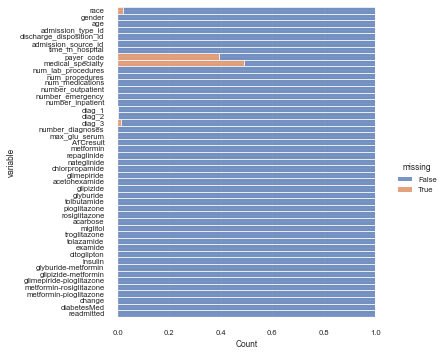

In [12]:
plt.figure(figsize=(50,100))
sns.set(font_scale = 0.7)
sns.displot(
    data=diab_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.1
)
#lt.xlabel(fontsize=16)

plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=400)

## Data cleaning

In [13]:
## Data cleaning of missing values 

# If Race set to ? - reassign as 'unknown'
diab_df['race'] =  diab_df['race'].fillna('Unknown')
diab_df['medical_specialty'] =  diab_df['medical_specialty'].fillna('Unknown')
diab_df['diag_1'] =  diab_df['diag_1'].fillna('No')
diab_df['diag_2'] =  diab_df['diag_2'].fillna('No')
diab_df['diag_3'] =  diab_df['diag_3'].fillna('No')



In [14]:
##Text to to ordinal 
#diab_df['readmitted'].replace(['NO','>30','<30'], [0,1,2], inplace=True)
diab_df['readmitted_binary'] = diab_df['readmitted'].replace(['NO','>30','<30'], [0,0,1])

## unknown admission type replaced with NA and then randomly imputed
#diab_df.admission_type_id = diab_df.admission_type_id.replace({5:np.nan, 6:np.nan, 8:np.nan})
#diab_df.admission_type_id.fillna(random.choice(diab_df.admission_type_id[~np.isnan(diab_df.admission_type_id)]),inplace = True)

In [15]:
diab_df.shape

(101766, 48)

In [16]:
diab_df.head(10)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary
0,Caucasian,Female,[0-10),6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,No,No,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0
1,Caucasian,Female,[10-20),1,1,7,3,NaN,Unknown,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,0
2,AfricanAmerican,Female,[20-30),1,1,7,2,NaN,Unknown,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,0
3,Caucasian,Male,[30-40),1,1,7,2,NaN,Unknown,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,0
4,Caucasian,Male,[40-50),1,1,7,1,NaN,Unknown,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,0
5,Caucasian,Male,[50-60),2,1,2,3,NaN,Unknown,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,0
6,Caucasian,Male,[60-70),3,1,2,4,NaN,Unknown,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,0
7,Caucasian,Male,[70-80),1,1,7,5,NaN,Unknown,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30,0
8,Caucasian,Female,[80-90),2,1,4,13,NaN,Unknown,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,0
9,Caucasian,Female,[90-100),3,3,4,12,NaN,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,0


In [17]:
# New variables 
diab_df['hosp_encounters_year'] =  diab_df['number_outpatient'] + diab_df['number_inpatient'] + diab_df['number_emergency']

# Recode some variables - all medication which have up/down/steady/no recoded to yes or no 
diab_df = diab_df.replace('Up','Yes')
diab_df = diab_df.replace('Steady','Yes')
diab_df = diab_df.replace('Down','Yes')

#just checking it worked
#diab_df1.to_csv('Output_check.csv', index = False)

In [18]:
##Discharge disposition - drop rows where patient died as cannot be readmitted
diab_df.discharge_disposition_id = diab_df.discharge_disposition_id.replace({11:np.nan, 19:np.nan, 20:np.nan, 21:np.nan})
diab_df = diab_df.dropna(subset=['discharge_disposition_id'])

## Data Cleaning ?? better

In [19]:
df = diab_df

df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')
#df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

cols_cat = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
df['med_spec'] = df['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

df[cols_cat_num] = df[cols_cat_num].astype('str')

df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

df = pd.concat([df,df_cat], axis = 1)

cols_all_cat = list(df_cat.columns)

age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
df['age_group'] = df.age.replace(age_id)

cols_extra = ['age_group']

print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

df[cols_num + cols_all_cat + cols_extra].isnull().sum().sort_values(ascending = False).head(10)

col2use = cols_num + cols_all_cat + cols_extra
df_data = df[col2use + ['OUTPUT_LABEL']]

Total number of features: 115
Numerical Features: 8
Categorical Features: 106
Extra features: 1


In [20]:
list(df_data)

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'race_Unknown',
 'gender_Male',
 'gender_Unknown/Invalid',
 'max_glu_serum_>300',
 'max_glu_serum_None',
 'max_glu_serum_Norm',
 'A1Cresult_>8',
 'A1Cresult_None',
 'A1Cresult_Norm',
 'metformin_Yes',
 'repaglinide_Yes',
 'nateglinide_Yes',
 'chlorpropamide_Yes',
 'glimepiride_Yes',
 'acetohexamide_Yes',
 'glipizide_Yes',
 'glyburide_Yes',
 'tolbutamide_Yes',
 'pioglitazone_Yes',
 'rosiglitazone_Yes',
 'acarbose_Yes',
 'miglitol_Yes',
 'troglitazone_Yes',
 'tolazamide_Yes',
 'insulin_Yes',
 'glyburide-metformin_Yes',
 'glipizide-metformin_Yes',
 'glimepiride-pioglitazone_Yes',
 'metformin-rosiglitazone_Yes',
 'metformin-pioglitazone_Yes',
 'change_No',
 'diabetesMed_Yes',
 'payer_code_CH',
 'payer_code_CM',
 'payer_code_CP',
 'payer_code_DM',
 'payer_cod

In [21]:
df_data.OUTPUT_LABEL

0         0
1         0
2         0
3         0
4         0
         ..
101761    0
101762    0
101763    0
101764    0
101765    0
Name: OUTPUT_LABEL, Length: 100114, dtype: int32

## Build training/Validation samples

In [58]:
# shuffle the samples

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)


# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)


print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

Split size: 0.300
Test prevalence(n = 15017):0.115
Valid prevalence(n = 15017):0.117
Train all prevalence(n = 70080):0.112


In [59]:
##Balanding the readmission samples due to unbalanced data 
#sub-sample the more dominant class: use a random subset of the negatives

# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 15742):0.500


In [60]:
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_test[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_test['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (70080, 115)
Training shapes: (15742, 115) (15742,)
Validation shapes: (15017, 115) (15017,)


### Scaling data

In [61]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

## Save scalar for test data
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [62]:
## Transform matrices

X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

## Model Selection

In [63]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

## As balanced training data 
thresh = 0.5

### Logistic regression

In [64]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [65]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.669
accuracy:0.619
recall:0.553
precision:0.637
specificity:0.685
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.661
recall:0.569
precision:0.185
specificity:0.673
prevalence:0.115
 


### Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [67]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.687
accuracy:0.634
recall:0.617
precision:0.639
specificity:0.652
prevalence:0.500
 
Validation:
AUC:0.655
accuracy:0.624
recall:0.600
precision:0.173
specificity:0.627
prevalence:0.115
 


### Gradient Boosting Classifier

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [69]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.767
accuracy:0.688
recall:0.670
precision:0.695
specificity:0.707
prevalence:0.500
 
Validation:
AUC:0.632
accuracy:0.606
recall:0.576
precision:0.161
specificity:0.609
prevalence:0.115
 


### K nearest neighbours (KNN)

In [70]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [71]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.648
accuracy:0.604
recall:0.500
precision:0.631
specificity:0.667
prevalence:0.500
 
Validation:
AUC:0.625
accuracy:0.671
recall:0.470
precision:0.168
specificity:0.649
prevalence:0.115
 


## Model Selection - feature importance

### Logistic regression feature importance

In [72]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [73]:
feature_importances.head()

,importance
number_inpatient,0.365699
discharge_disposition_id_22.0,0.175973
discharge_disposition_id_3.0,0.166137
discharge_disposition_id_5.0,0.125103
med_spec_Other,0.113103


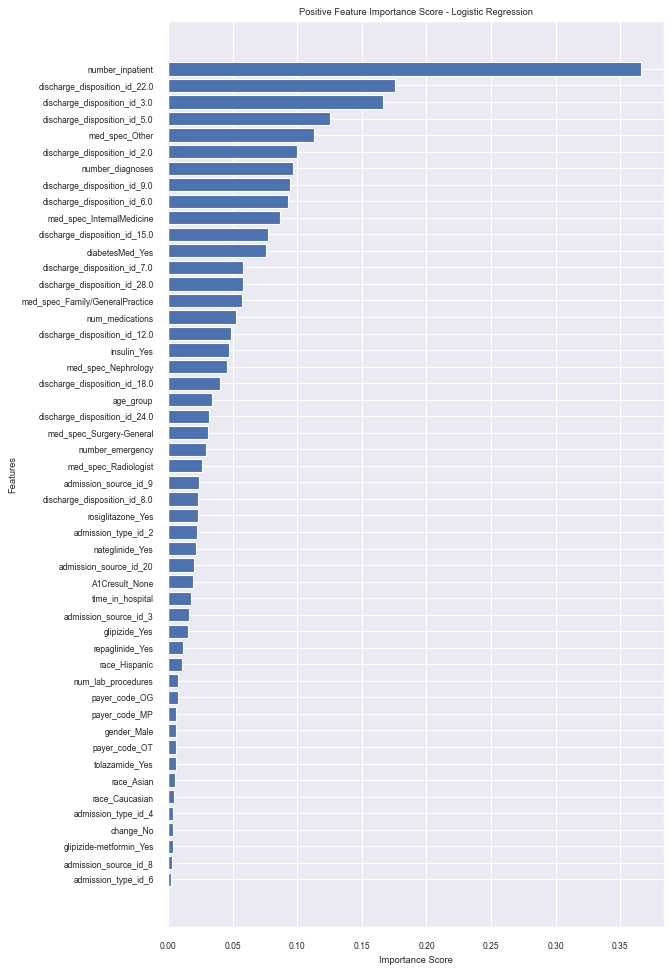

In [74]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

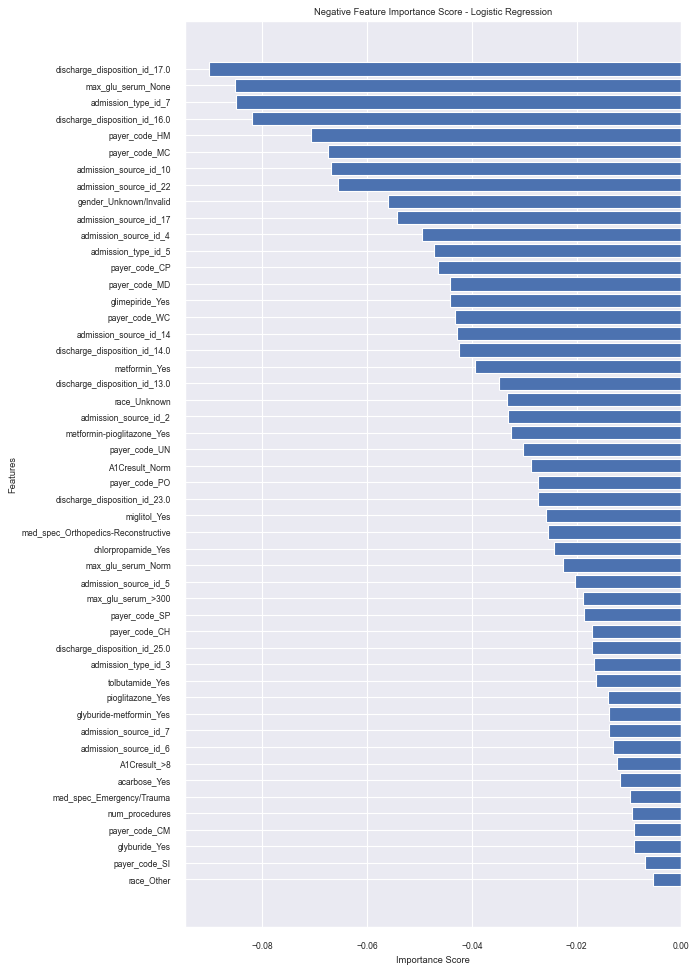

In [75]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

### Feature importance random forest 

In [76]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

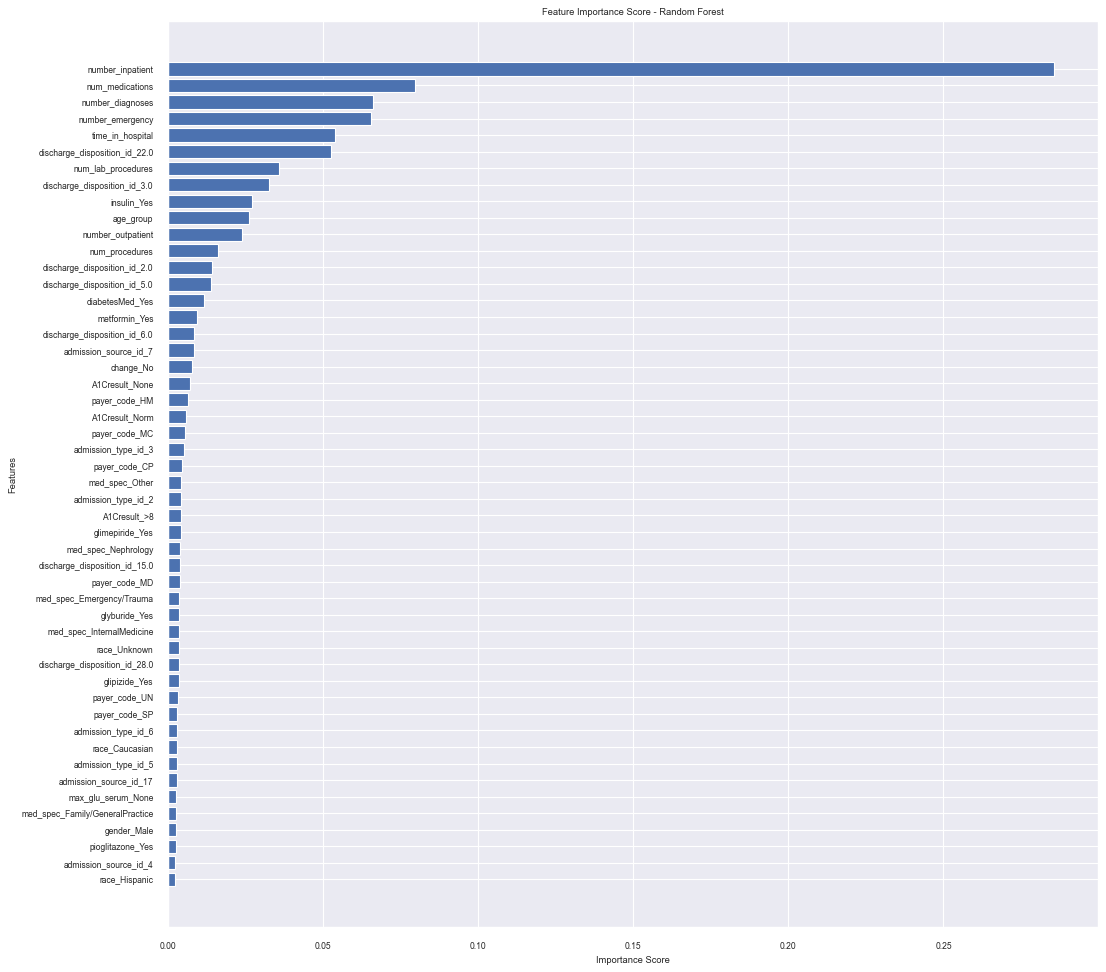

In [77]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
#plt.show()
plt.savefig("random_forest_feature_importance.png", dpi=400)

## Hyperparameter tuning 

### Random Forest

In [78]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(1,10,1)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

In [79]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [80]:
# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

In [81]:
# fit the random search model (this will take a few minutes)
#t1 = time.time()
rf_random.fit(X_train_tf, y_train)
#t2 = time.time()
#print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(max_depth=6,
                                                    random_state=42),
                   n_iter=20,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 10),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': range(2, 10, 2),
                                        'n_estimators': range(200, 1000, 200)},
                   random_state=42, scoring=make_scorer(roc_auc_score),
                   verbose=1)

In [82]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 6,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'gini'}

In [83]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_valid_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_valid_auc))

Baseline Random Forest
Training AUC:0.687
Validation AUC:0.655
Optimized Random Forest
Training AUC:0.717
Validation AUC:0.661


In [84]:
### Gradient Boosted

In [85]:
# number of trees
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc,
                                n_iter = 20, cv = 2, scoring=auc_scoring,
                                verbose = 0, random_state = 42)

In [86]:
gbc_random.fit(X_train_tf, y_train)

RandomizedSearchCV(cv=2,
                   estimator=GradientBoostingClassifier(learning_rate=1.0,
                                                        random_state=42),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': range(1, 5),
                                        'n_estimators': range(100, 500, 100)},
                   random_state=42, scoring=make_scorer(roc_auc_score))

In [87]:
gbc_random.best_params_

{'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1}

In [88]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Baseline gbc')
gbc_train_auc_base = roc_auc_score(y_train, y_train_preds)
gbc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_auc_base))
print('Validation AUC:%.3f'%(gbc_valid_auc_base))

print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_auc))
print('Validation AUC:%.3f'%(gbc_valid_auc))

Baseline gbc
Training AUC:0.767
Validation AUC:0.632
Optimized gbc
Training AUC:0.684
Validation AUC:0.669


In [89]:
### Summary results

In [90]:
df_results = pd.DataFrame({'classifier':['RF','RF','GB','GB'],
                           'data_set':['base','optimized']*2,
                          'auc':[rf_valid_auc_base,rf_valid_auc,
                                 gbc_valid_auc_base,gbc_valid_auc,],
                          })

In [91]:
df_results

,classifier,data_set,auc
0,RF,base,0.654758
1,RF,optimized,0.661447
2,GB,base,0.632324
3,GB,optimized,0.669416


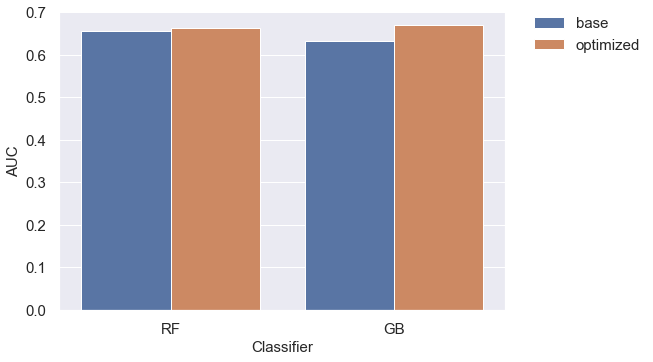

In [92]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.savefig("AUC_random_forest_gradient_boosted_hyperparameter_tuned.png", dpi=400)

## Data Cleaning like other

For each nominal catagorical variables 
- dummify 
- drop common values 
- add dummy columns back to original data base

In [93]:
# df = diab_df

# # Race
# races = pd.get_dummies(df['race'])
# races = races.drop(columns = ['Unknown', 'Caucasian'])
# # We add the the dummy columns back to the original dataframe
# df = pd.concat([df, races], axis=1)
# df = df.drop(columns = ['race'])

# # Gender
# genders = pd.get_dummies(df['gender'])
# genders = genders.drop(columns = ['Female'])
# # We add the the dummy column back to the original dataframe
# df = pd.concat([df, genders], axis=1)
# df = df.drop(columns = ['gender'])

# #Age - make numeric by choosing lower bound
# age = df["age"]

# # We replace each age bin with its lower bound divided by 10
# for i in range(10):
#     age = age.replace("["+str(10*i)+"-"+str(10*(i+1))+")", i)

# df['age'] = age

# #Admission type
# admission_type = pd.get_dummies(df['admission_type_id'])
# print(df['admission_type_id'].value_counts())

# # The most common admission type of the patients is Emergency (1), so we drop that column.
# # The missingness is sparse enough (about 10%) that we can drop those columns (5, 6, and 8) without losing very much information.
# admission_type = admission_type.drop(columns = [1, 5, 6, 8])

# # We add the the dummy columns back to the original dataframe
# df = pd.concat([df, admission_type], axis=1)
# df = df.drop(columns = ['admission_type_id'])

# ##Discharge Disposition 
# discharge_disposition = pd.get_dummies(df['discharge_disposition_id'])
# print(df['discharge_disposition_id'].value_counts())

# # The most common discharge type of the patients is Discharged to Home (1), so we drop that column.
# # The missingness is sparse enough (about 4.5%) that we can drop those columns (18 and 25) without losing very much information.
# discharge_disposition = discharge_disposition.drop(columns = [1, 18, 25])

# # We add the the dummy columns back to the original dataframe
# df = pd.concat([df, discharge_disposition], axis=1)
# df = df.drop(columns = ['discharge_disposition_id'])

# #admission source
# admission_source = pd.get_dummies(df['admission_source_id'])
# print(df['admission_source_id'].value_counts())

# # The most common route of admission is from the emergency room (7), so we drop that column.
# # The missingness is sparse enough (about 7%) that we can drop it without losing very much information.
# admission_source = admission_source.drop(columns = [7, 17, 9, 20])

# # We add the the dummy columns back to the original dataframe
# df = pd.concat([df, admission_source], axis=1)
# df = df.drop(columns = ['admission_source_id'])


# ##Medical Specialty 
# medical_specialty = pd.get_dummies(df['medical_specialty'])
# #print(df['medical_specialty'].value_counts())

# # The missingness is rampant in this column (53%). Though we will still drop this column, we cannot drop the most common
# # non-missing column, Internal Medicine. If we did do this, our model would assume that a missing specialty of the doctor
# # is really internal medicine, which we do not want. As an aside, sometimes it is okay to impute by the most common class, but
# # we will not be doing this.

# # Here we drop the column displaying the missingness.
# medical_specialty = medical_specialty.drop(columns = ['Unknown'])

# # As there are 84 medical specialties, we do not wish to try to model every specialty, because there are just too many.
# # We would require more data, lots of computing power, and potentially a lot of time.
# # Instead we only model the specialties of doctors that treated at least 1% of patients in our data set.
# # Of course, 1% is arbitrary.
# treated_onepercent = list(df['medical_specialty'].value_counts()[1:10].index)
# medical_specialty = medical_specialty.drop(columns = treated_onepercent)

# # We add the the dummy columns back to the original dataframe
# df = pd.concat([df, medical_specialty], axis=1)
# df = df.drop(columns = ['medical_specialty'])

# ##Diagnoses 
# # For the diagonosis columns we need to perform a more detailed dummification of the variables becuase all three columns need to
# # be distributed into the various dummified variables.

# # For the three diagnosis columns, we first change the icd9 codes into the group name of the disease for which the patient was
# # admitted. The types of diseases are circulatory, respiratory, digestive, diabetes, injury, musculoskeletal, genitourinary,
# # neoplasms, and other.
# diagnoses = df[['diag_1', 'diag_2', 'diag_3']]

# # These are lists of the icd9 codes for illness contained within the nine illness groups
# circulatory_icd9_codes = list(map(str, range(390, 460))) + ['785']
# respiratory_icd9_codes = list(map(str, range(460, 520))) + ['786']
# digestive_icd9_codes = list(map(str, range(520, 580))) + ['787']
# diabetes_icd9_codes = list(map(str, list(np.linspace(250, 251, 100, endpoint = False)))) + ['250']
# injury_icd9_codes = list(map(str, range(800, 1000)))
# musculoskeletal_icd9_codes = list(map(str, range(710, 740)))
# genitourinary_icd9_codes = list(map(str, range(580, 630))) + ['788']
# neoplasms_icd9_codes = list(map(str, range(140, 240)))
# other_codes = (list(map(str, range(1, 800))) + 
#                list(map(lambda x: 'V0' + str(x), range(0, 10))) +
#                list(map(lambda x: 'V' + str(x), range(10, 100))) + 
#                list(map(lambda x: 'E' + str(x), range(800, 1000))) +
#                ['365.44']
#               )
# # We change the icd9 codes to the respective illness group
# diagnoses = diagnoses.replace(circulatory_icd9_codes, 'circulatory')
# diagnoses = diagnoses.replace(respiratory_icd9_codes, 'respiratory')
# diagnoses = diagnoses.replace(digestive_icd9_codes, 'digestive')
# diagnoses = diagnoses.replace(diabetes_icd9_codes, 'diabetes')
# diagnoses = diagnoses.replace(injury_icd9_codes, 'injury')
# diagnoses = diagnoses.replace(musculoskeletal_icd9_codes, 'musculoskeletal')
# diagnoses = diagnoses.replace(genitourinary_icd9_codes, 'genitourinary')
# diagnoses = diagnoses.replace(neoplasms_icd9_codes, 'neoplasms')
# diagnoses = diagnoses.replace(other_codes, 'other')

# # Next we dummify and then add the dummifed columns together
# diag_1 = pd.get_dummies(diagnoses['diag_1'])
# diag_2 = pd.get_dummies(diagnoses['diag_2'])
# diag_3 = pd.get_dummies(diagnoses['diag_3'])
# dummy_diag = diag_1 + diag_2 + diag_3

# # The missingness is sparse enough that we can drop it without losing very much information.
# # Since we cannot deduce the illness group of a patient with the other collumns, there is not that much multicollinearity, so
# # we need not drop the most common column.
# #dummy_diag = dummy_diag.drop(columns = ['Unknown'])

# # We add the the dummy columns back to the original dataframe
# df = pd.concat([df, dummy_diag], axis=1)
# df = df.drop(columns = ['diag_1', 'diag_2', 'diag_3'])


# ##HBA1C results
# A1Cresult = pd.get_dummies(df['A1Cresult'])
# print(df['A1Cresult'].value_counts())

# # The most common A1C test value is None, indicating that it was not taken. Ordinarily, we would drop the dummified column of
# # None because we usually can be sure it isn't statistically significant. However, in this case, the conclusion of the research
# # paper clearly states that whether or not Hemoglobin A1C was measured is very important in predicting readission. Thus it is
# # imperative that we retain the None column.

# # We add the the dummy columns back to the original dataframe
# df = pd.concat([df, A1Cresult], axis=1)
# df = df.drop(columns = ['A1Cresult'])

# ##Medications 

# # We drop the 15 medications that are barely taken or prescribed. We use the criteria that we only include the ones that are taken
# # or prescribed by at least 1% of patients.
# barely_used = ['nateglinide',
#                'chlorpropamide',
#                'acetohexamide',
#                'tolbutamide',
#                'acarbose',
#                'miglitol',
#                'troglitazone',
#                'tolazamide',
#                'examide',
#                'citoglipton',
#                'glyburide-metformin',
#                'glipizide-metformin',
#                'glimepiride-pioglitazone',
#                'metformin-rosiglitazone',
#                'metformin-pioglitazone'               
#               ]
# df = df.drop(columns = barely_used)

# # We dummify each of the remaining eight medicine columns:
# used_medicine_strings = ['metformin',
#                          'repaglinide',
#                          'glimepiride',
#                          'glipizide',
#                          'glyburide',
#                          'pioglitazone',
#                          'rosiglitazone',
#                          'insulin']
# used_medicine_dfs = [df[medicine] for medicine in used_medicine_strings]

# for i in range(len(used_medicine_strings)):
#     used_medicine_dfs[i] = pd.get_dummies(df[used_medicine_strings[i]])
    
#     # For each of the remaining medicines, the most common value is No, which stands for the medication not being taken or
# # prescribed. Since, we do not have any missingness for these columns, we can drop this most common value from the dummified
# # data frames.

# for medicine in used_medicine_dfs:
#     medicine = medicine.drop(columns = ['No'])
    
#     # Now we add the dummy columns back to the original dataframe and delete the original columns.
# df = pd.concat([df] + used_medicine_dfs, axis = 1)
# df = df.drop(columns = used_medicine_strings)

# # Lastly for the data cleaning process is to drop the two extraneous columns that record whether there was a change in diabetic
# # medicatin or if any diabetic medication was prescribed. These two columns are extraneous because the medicine columns that
# # we just added to the main df contain all the information from the extraneous ones.
# df = df.drop(columns=['change', 'diabetesMed'])


In [94]:
list(df.columns)

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted',
 'readmitted_binary',
 'hosp_encounters_year',
 'OUTPUT_LABEL',
 'med_spec',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'race_Unknown',
 'gender_Male',


In [95]:
##What kind of columns do we have
numer_columns = df.select_dtypes(include=['float64', 'int64']).columns
print(numer_columns)
print("numerical features : " + str(len(numer_columns)))

catag_columns = df.select_dtypes(['object']).columns
print(catag_columns)

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'readmitted_binary',
       'hosp_encounters_year', 'age_group'],
      dtype='object')
numerical features : 11
Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'med_spec'],
 

In [96]:
list(df)

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted',
 'readmitted_binary',
 'hosp_encounters_year',
 'OUTPUT_LABEL',
 'med_spec',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'race_Unknown',
 'gender_Male',


In [97]:
## Recheck missing values

<Figure size 3600x7200 with 0 Axes>

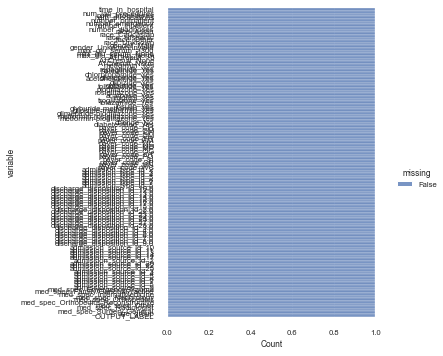

In [98]:
plt.figure(figsize=(50,100))
sns.set(font_scale = 0.7)
sns.displot(
    data=df_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.1
)
#lt.xlabel(fontsize=16)

plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=400)

## Exploratory data analysis

In [99]:
## Variables at a glance

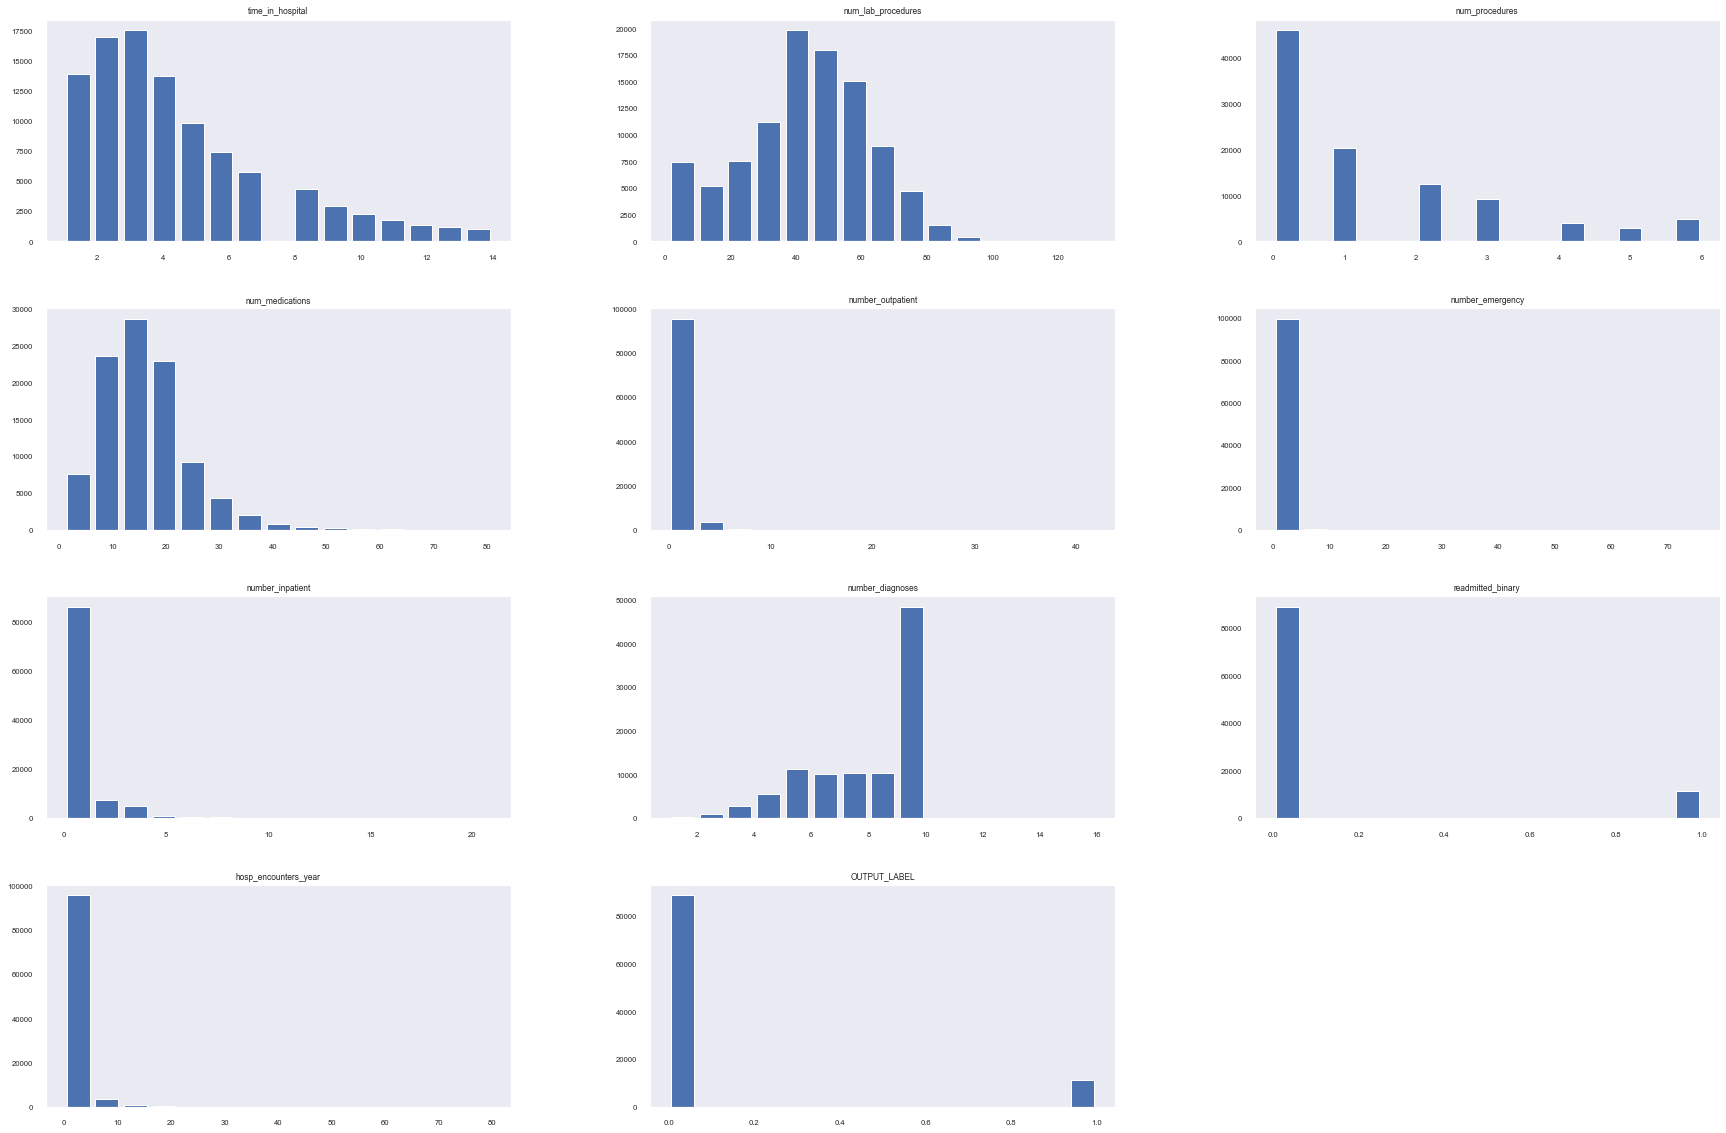

In [100]:
plt.rcParams.update({'font.size': 22})
#df_data.hist(figsize=(30,20), grid=False, rwidth=0.8, bins=15)
diab_df.hist(figsize=(30,20), grid=False, rwidth=0.8, bins=15)
plt.savefig("variables_histogram.jpg", dpi=400)


In [101]:
## Diagnoses 
## Merge with ICD9 codes 


diab_df1 = pd.merge(diab_df, icd9, left_on="diag_1", right_on="icd9code")
diab_df1.head(10)


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,...,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary,hosp_encounters_year,OUTPUT_LABEL,med_spec,icd9code,long_description,short_description
0,Caucasian,Female,[0-10),6,25.0,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,No,No,1,None,None,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0,0,Other,250.83,Diabetes with other specified manifestations -...,DMI oth uncntrld
1,Caucasian,Male,[20-30),6,25.0,7,1,NaN,InternalMedicine,56,0,6,0,0,0,250.83,276,461,6,None,None,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,Ch,Yes,NO,0,0,0,InternalMedicine,250.83,Diabetes with other specified manifestations -...,DMI oth uncntrld
2,AfricanAmerican,Male,[50-60),6,25.0,7,3,NaN,Endocrinology,46,5,15,0,0,0,250.83,996,428,9,None,>8,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,Ch,Yes,NO,0,0,0,Other,250.83,Diabetes with other specified manifestations -...,DMI oth uncntrld
3,Caucasian,Female,[10-20),2,1.0,1,1,NaN,Pediatrics-Endocrinology,11,0,4,0,0,0,250.83,787,780,3,None,>8,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Yes,NO,0,0,0,Other,250.83,Diabetes with other specified manifestations -...,DMI oth uncntrld
4,AfricanAmerican,Female,[50-60),1,1.0,7,3,NaN,Pulmonology,55,0,6,0,0,0,250.83,E932,278,7,None,>8,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Yes,NO,0,0,0,Other,250.83,Diabetes with other specified manifestations -...,DMI oth uncntrld
5,Caucasian,Female,[40-50),6,1.0,7,4,NaN,InternalMedicine,58,0,12,0,0,0,250.83,682,276,5,>300,None,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30,0,0,0,InternalMedicine,250.83,Diabetes with other specified manifestations -...,DMI oth uncntrld
6,Caucasian,Female,[30-40),1,1.0,7,1,NaN,Endocrinology,31,0,2,0,0,0,250.83,910,E885,3,None,None,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30,0,0,0,Other,250.83,Diabetes with other specified manifestations -...,DMI oth uncntrld
7,AfricanAmerican,Female,[10-20),1,1.0,7,3,NaN,Pediatrics-CriticalCare,43,0,4,0,0,0,250.83,No,No,1,None,>8,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Yes,>30,0,0,0,Other,250.83,Diabetes with other specified manifestations -...,DMI oth uncntrld
8,Caucasian,Female,[50-60),1,6.0,7,9,NaN,InternalMedicine,51,6,15,0,0,0,250.83,730,682,9,None,>8,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,Ch,Yes,NO,0,0,0,InternalMedicine,250.83,Diabetes with other specified manifestations -...,DMI oth uncntrld
9,Caucasian,Female,[10-20),1,1.0,7,3,NaN,Pediatrics-Endocrinology,55,0,3,0,0,0,250.83,No,No,1,None,>8,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Yes,>30,0,0,0,Other,250.83,Diabetes with other specified manifestations -...,DMI oth uncntrld


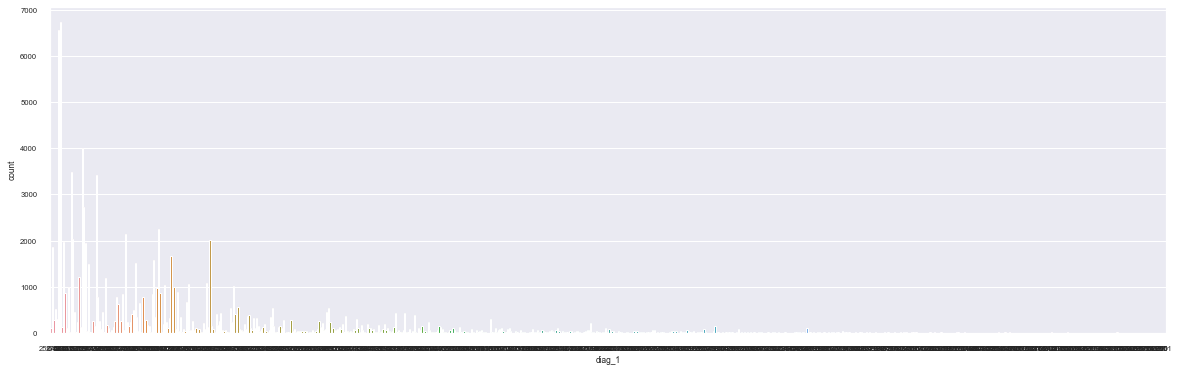

In [102]:
##Top 10 diagnoses 
plt.figure(figsize=(20,6)) 
sns.countplot(x='diag_1', data=diab_df) 
plt.show()
#sns.barplot(data=g, x='diag_1', y='diag_1', hue='diag_1', dodge=False).set(xticklabels=[]);


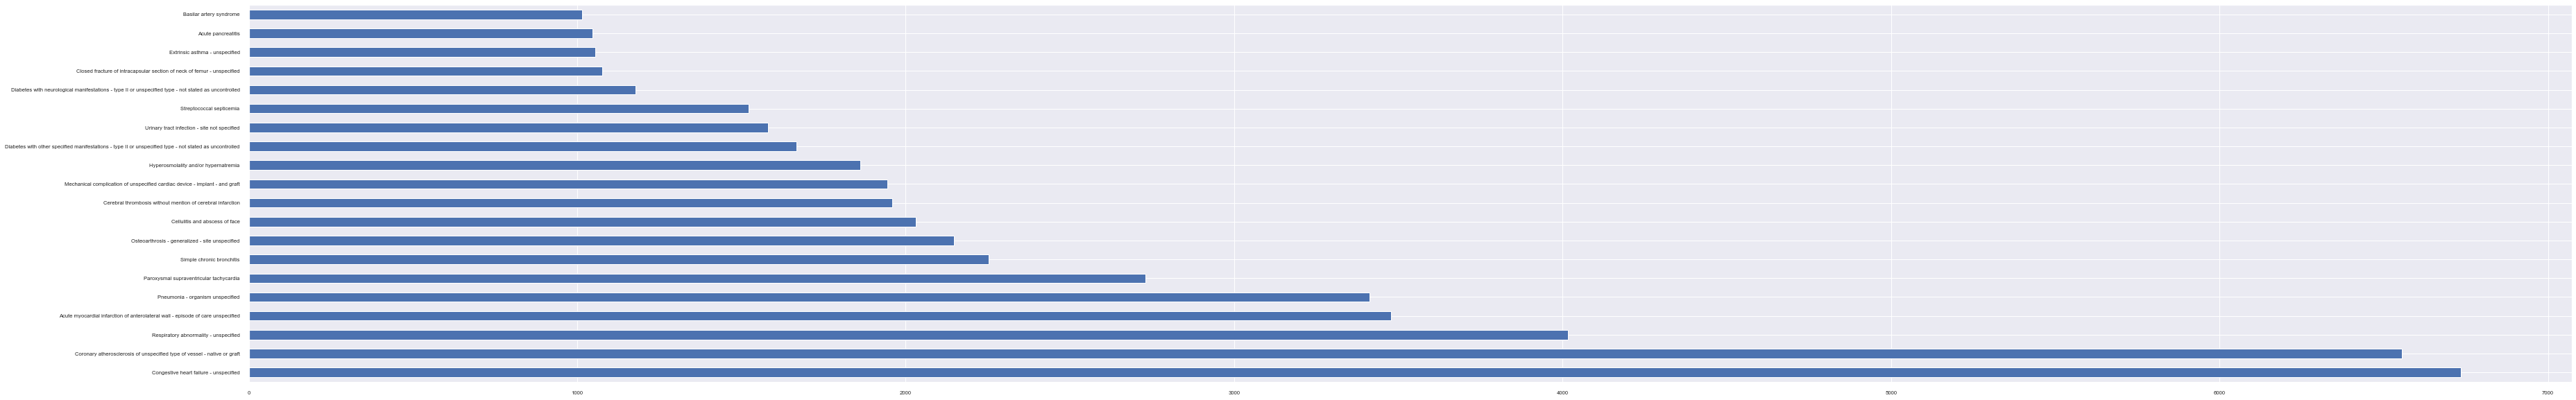

In [103]:
plt.figure(figsize=(60,10)) 
diab_df1['long_description'].value_counts()[:20].plot(kind='barh')
plt.savefig("diag_1_top20.jpg", dpi=400)

In [104]:
diab_df2 = pd.merge(diab_df, icd9, left_on="diag_2", right_on="icd9code")

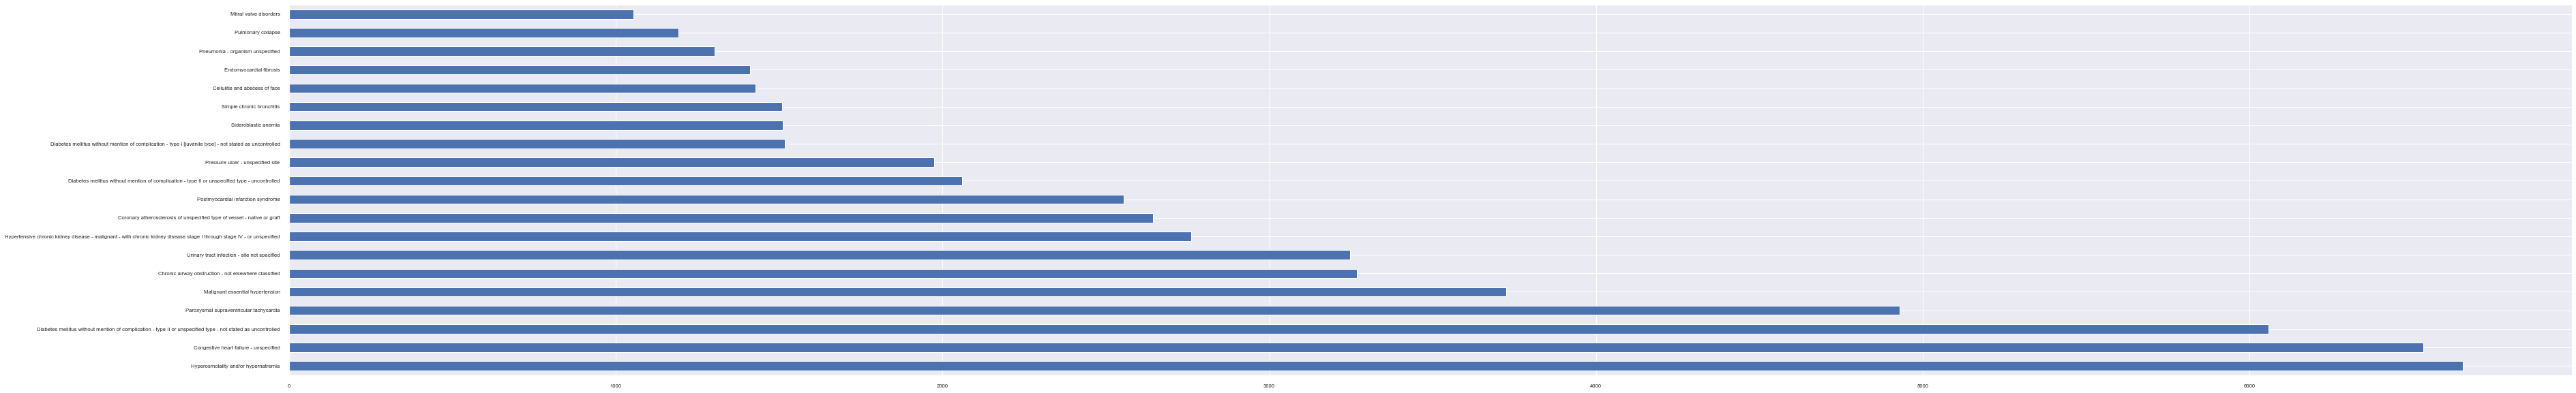

In [105]:
plt.figure(figsize=(60,10)) 
diab_df2['long_description'].value_counts()[:20].plot(kind='barh')
plt.savefig("diag_2_top20.jpg", dpi=400)

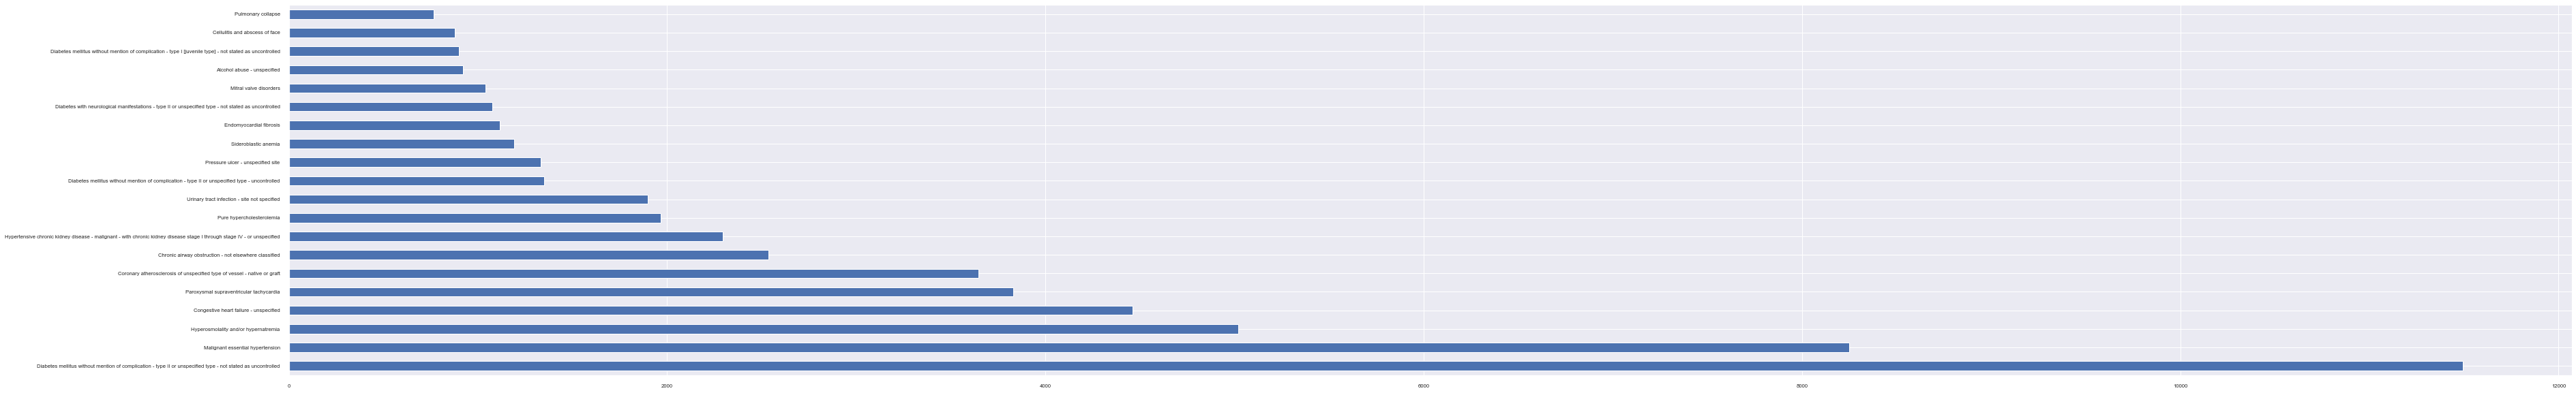

In [106]:
diab_df3 = pd.merge(diab_df, icd9, left_on="diag_3", right_on="icd9code")
plt.figure(figsize=(60,10)) 
diab_df3['long_description'].value_counts()[:20].plot(kind='barh')
plt.savefig("diag_3_top20.jpg", dpi=400)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Asian'),
  Text(0, 1, 'Other'),
  Text(0, 2, 'Hispanic'),
  Text(0, 3, 'Unknown'),
  Text(0, 4, 'AfricanAmerican'),
  Text(0, 5, 'Caucasian')])

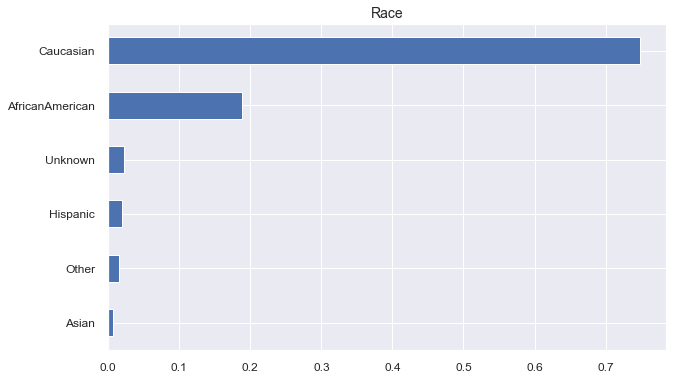

In [107]:
# Race plot
plt.figure(figsize=(10,6))
race_p = diab_df.race.value_counts().sort_values().apply(lambda x: x/diab_df.race.count()).plot(kind='barh')
plt.title('Race',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0, 1]), [Text(0, 0, 'Male'), Text(0, 1, 'Female')])

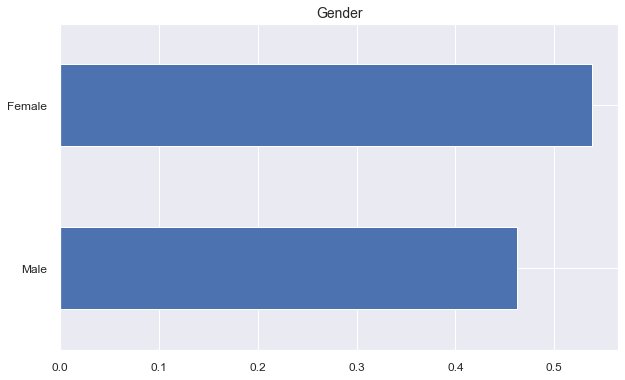

In [108]:
# Gender plot
plt.figure(figsize=(10,6))
race_p = diab_df.gender[diab_df.gender!='Unknown/Invalid'].value_counts().sort_values().apply(lambda x: x/diab_df.race.count()).plot(kind='barh')
plt.title('Gender',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '[0-10)'),
  Text(0, 1, '[10-20)'),
  Text(0, 2, '[20-30)'),
  Text(0, 3, '[90-100)'),
  Text(0, 4, '[30-40)'),
  Text(0, 5, '[40-50)'),
  Text(0, 6, '[80-90)'),
  Text(0, 7, '[50-60)'),
  Text(0, 8, '[60-70)'),
  Text(0, 9, '[70-80)')])

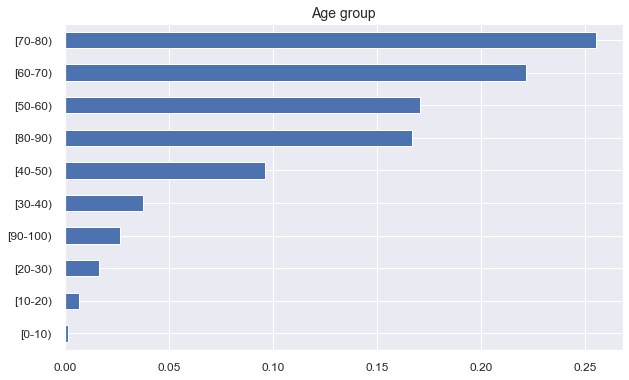

In [109]:

# Age plot
plt.figure(figsize=(10,6))
race_p = diab_df.age.value_counts().sort_values().apply(lambda x: x/diab_df.age.count()).plot(kind='barh')
plt.title('Age group',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0, 1, 2, 3]),
 [Text(0, 0, '>7'), Text(0, 1, 'Norm'), Text(0, 2, '>8'), Text(0, 3, 'None')])

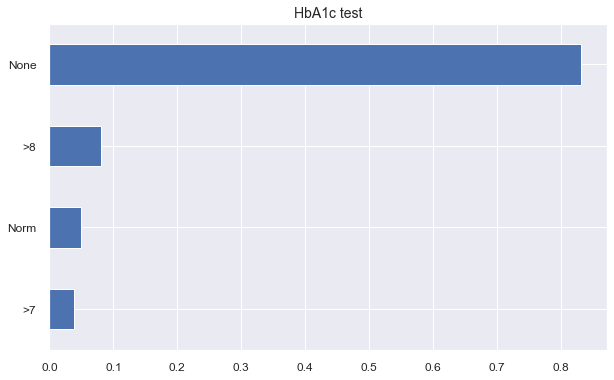

In [110]:
# HbA1c plot
plt.figure(figsize=(10,6))
race_p = diab_df.A1Cresult.value_counts().sort_values().apply(lambda x: x/diab_df.race.count()).plot(kind='barh')
plt.title('HbA1c test',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0, 1]), [Text(0, 0, 'Ch'), Text(0, 1, 'No')])

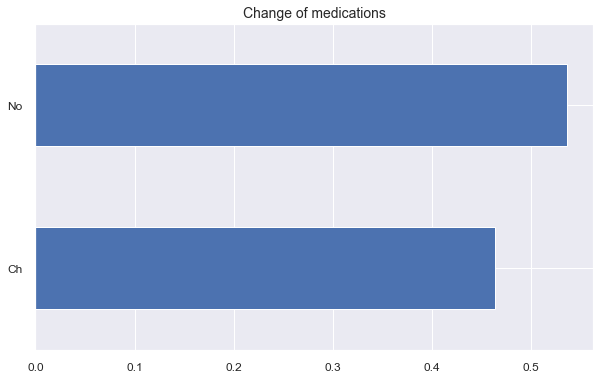

In [111]:
# Med change plot
plt.figure(figsize=(10,6))
race_p = diab_df.change.value_counts().sort_values().apply(lambda x: x/diab_df.change.count()).plot(kind='barh')
plt.title('Change of medications',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

([<matplotlib.axis.YTick at 0x1e61a1efee0>,
 [Text(0, 0, '<30 days'), Text(0, 1, '>30 days'), Text(0, 2, 'No')])

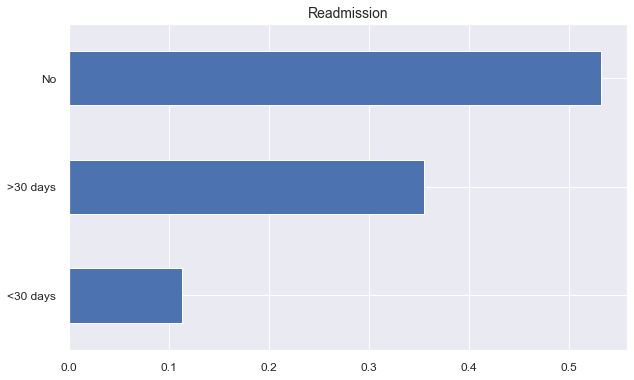

In [112]:
# Readmission plot
plt.figure(figsize=(10,6))
race_p = diab_df.readmitted.value_counts().sort_values().apply(lambda x: x/diab_df.race.count()).plot(kind='barh')
plt.title('Readmission',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks([0, 1, 2], ['<30 days', '>30 days', 'No'],fontsize=12)

#xticks([0, 1, 2], ['January', 'February', 'March'],

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

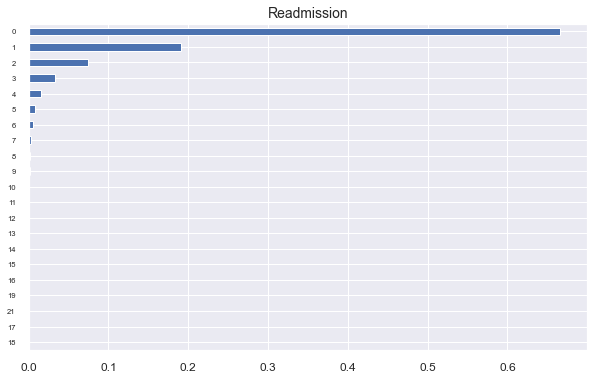

In [113]:
# Number inpatient admissions in previous year
plt.figure(figsize=(10,6))
race_p = diab_df.number_inpatient.value_counts().sort_values().apply(lambda x: x/diab_df.number_inpatient.count()).plot(kind='barh')
plt.title('Readmission',fontsize=14)
plt.xticks(fontsize=12)
#plt.yticks([0, 1, 2], ['<30 days', '>30 days', 'No'],fontsize=12)

#xticks([0, 1, 2], ['January', 'February', 'March'],

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1800x1296 with 0 Axes>

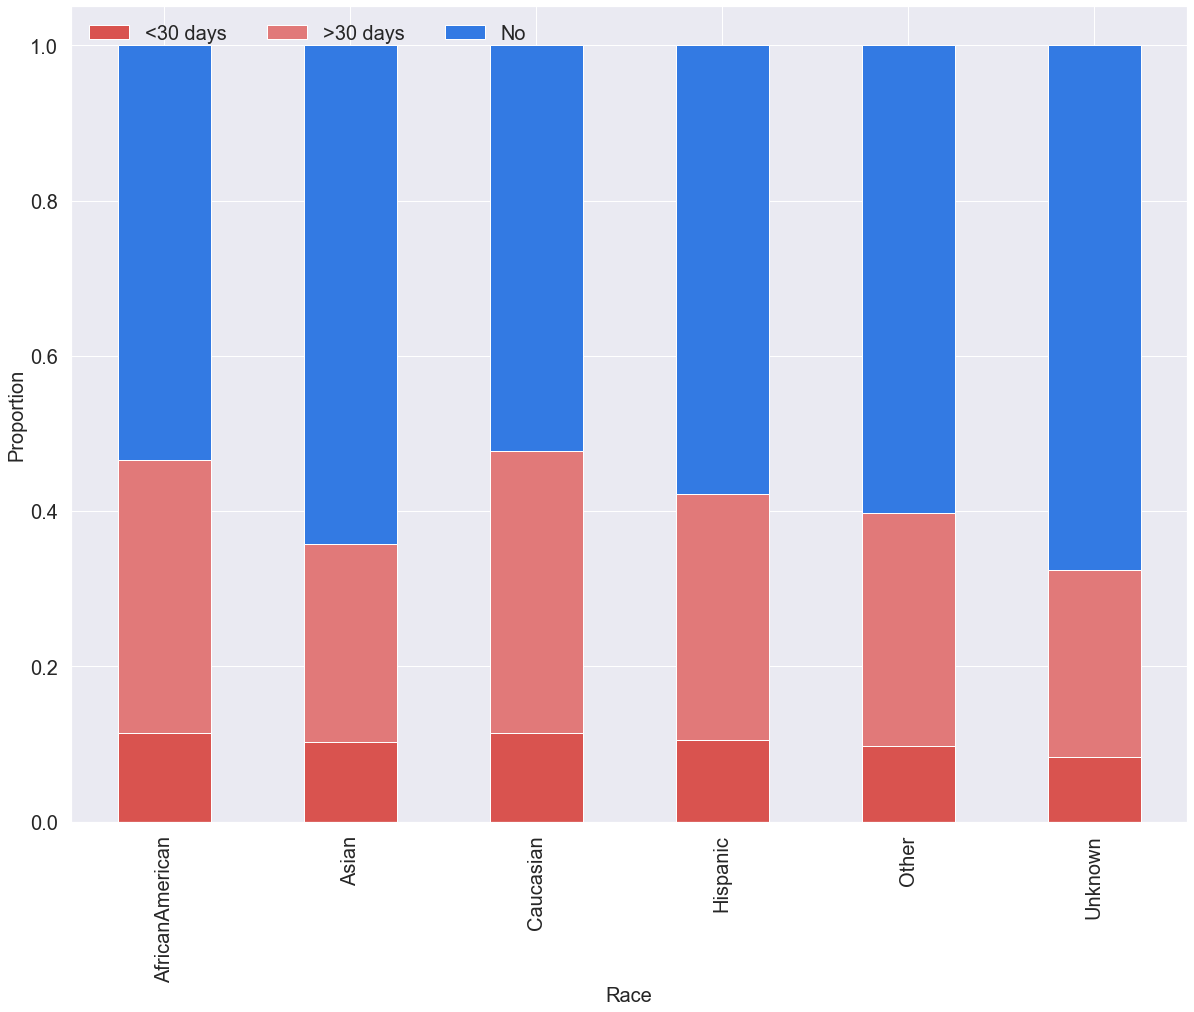

In [114]:
##Proportional table - readmission vs race
#https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b

cross_tab_prop = pd.crosstab(index=diab_df['race'],
                             columns=diab_df['readmitted'],
                             normalize='index')
cross_tab_prop

plt.figure(figsize=(25, 18))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    color=['#d9534f','#E17979', '#337AE3'],
                    figsize=(20, 15))

plt.legend(["<30 days",">30 days", "No"], loc="upper left", fontsize=20, ncol=3)
plt.xlabel("Race", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.savefig("BMI_diabetes_stacked_bar_graph.jpg", dpi=400)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1800x1296 with 0 Axes>

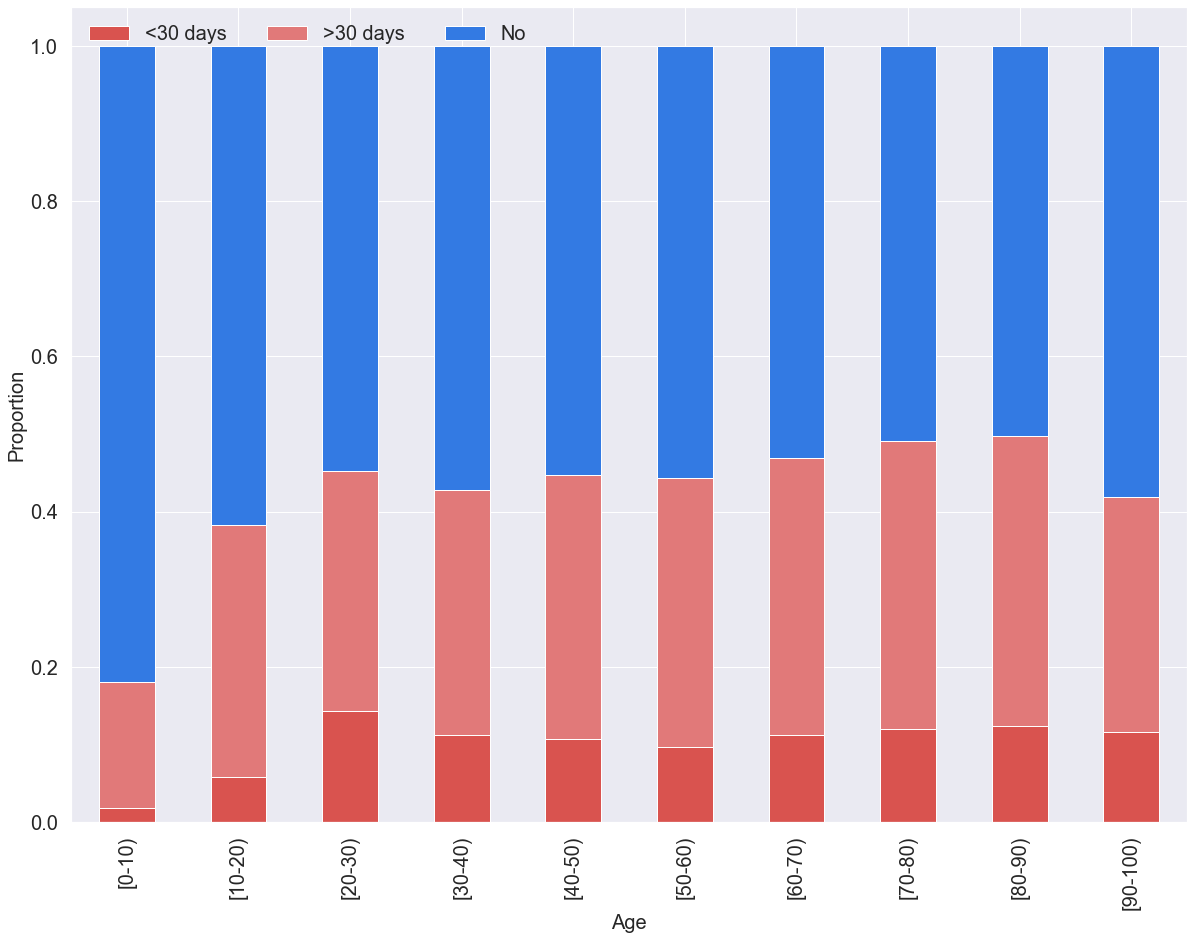

In [115]:
##Proportional table 
#https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b
cross_tab_prop = pd.crosstab(index=diab_df['age'],
                             columns=diab_df['readmitted'],
                             normalize='index')

plt.figure(figsize=(25, 18))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    color=['#d9534f','#E17979', '#337AE3'],
                    figsize=(20, 15))

plt.legend(["<30 days",">30 days", "No"], loc="upper left", ncol=3, fontsize=20)
plt.xlabel("Age", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.savefig("BMI_diabetes_stacked_bar_graph.jpg", dpi=400)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1800x1296 with 0 Axes>

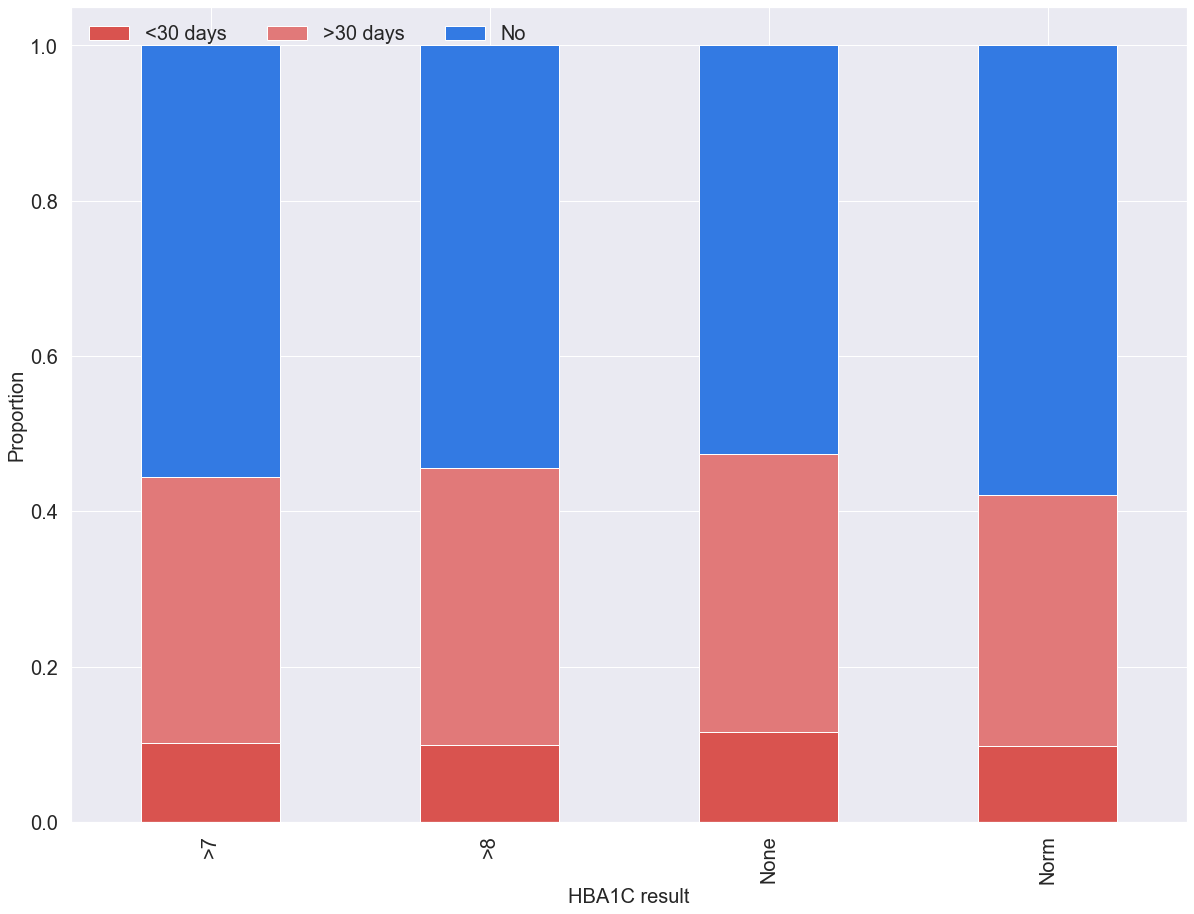

In [116]:
##Proportional table 
#https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b

cross_tab_prop = pd.crosstab(index=diab_df['A1Cresult'],
                             columns=diab_df['readmitted'],
                             normalize='index')

plt.figure(figsize=(25, 18))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    color=['#d9534f','#E17979', '#337AE3'],
                    figsize=(20, 15))

plt.legend(["<30 days",">30 days", "No"], loc="upper left", ncol=3, fontsize=20)
plt.xlabel("HBA1C result", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.savefig("BMI_diabetes_stacked_bar_graph.jpg", dpi=400)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1800x1296 with 0 Axes>

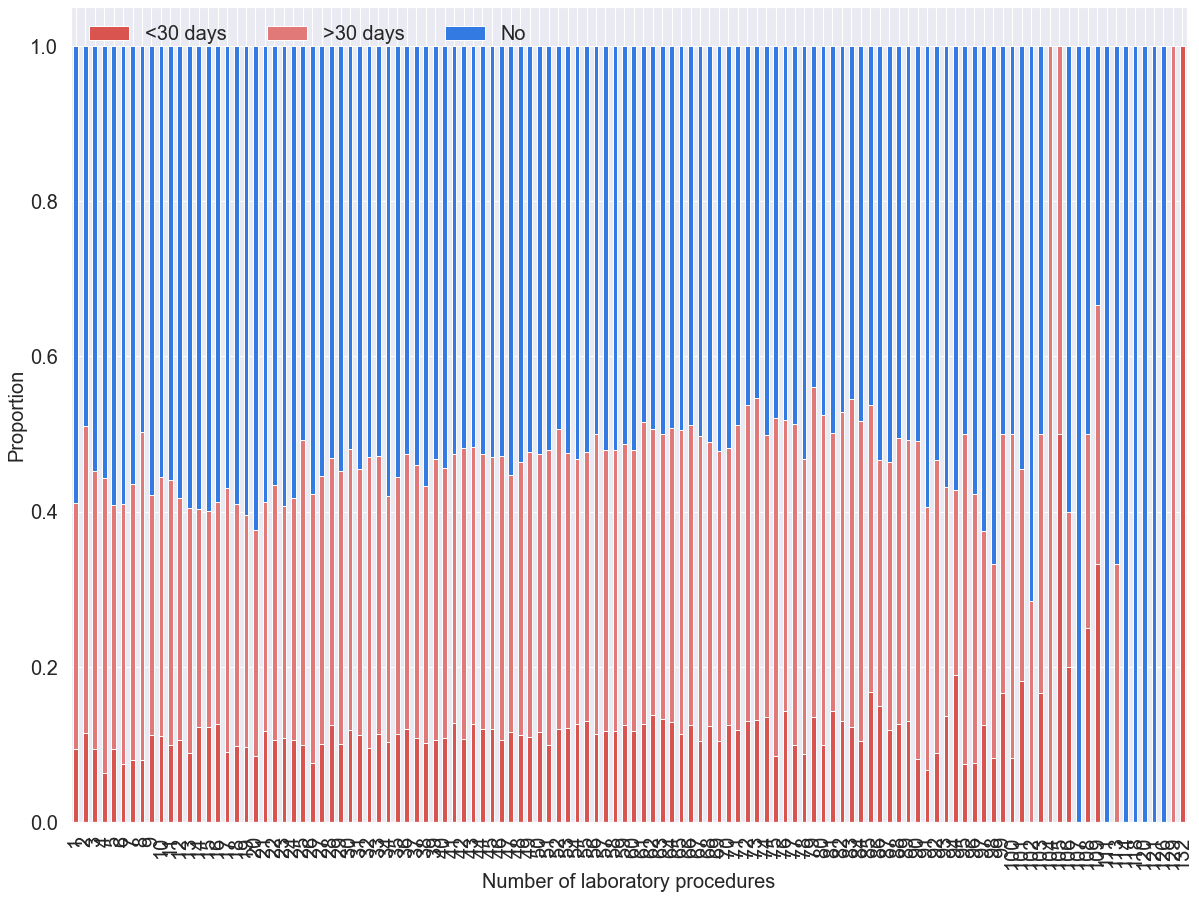

In [117]:
##Proportional table 
#https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b
cross_tab_prop = pd.crosstab(index=diab_df['num_lab_procedures'],
                             columns=diab_df['readmitted'],
                             normalize='index')
plt.figure(figsize=(25, 18))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    color=['#d9534f','#E17979', '#337AE3'],
                    figsize=(20, 15))

plt.legend(["<30 days",">30 days", "No"], loc="upper left", ncol=3, fontsize=20)
plt.xlabel("Number of laboratory procedures", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig("BMI_diabetes_stacked_bar_graph.jpg", dpi=400)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<Figure size 1800x1296 with 0 Axes>

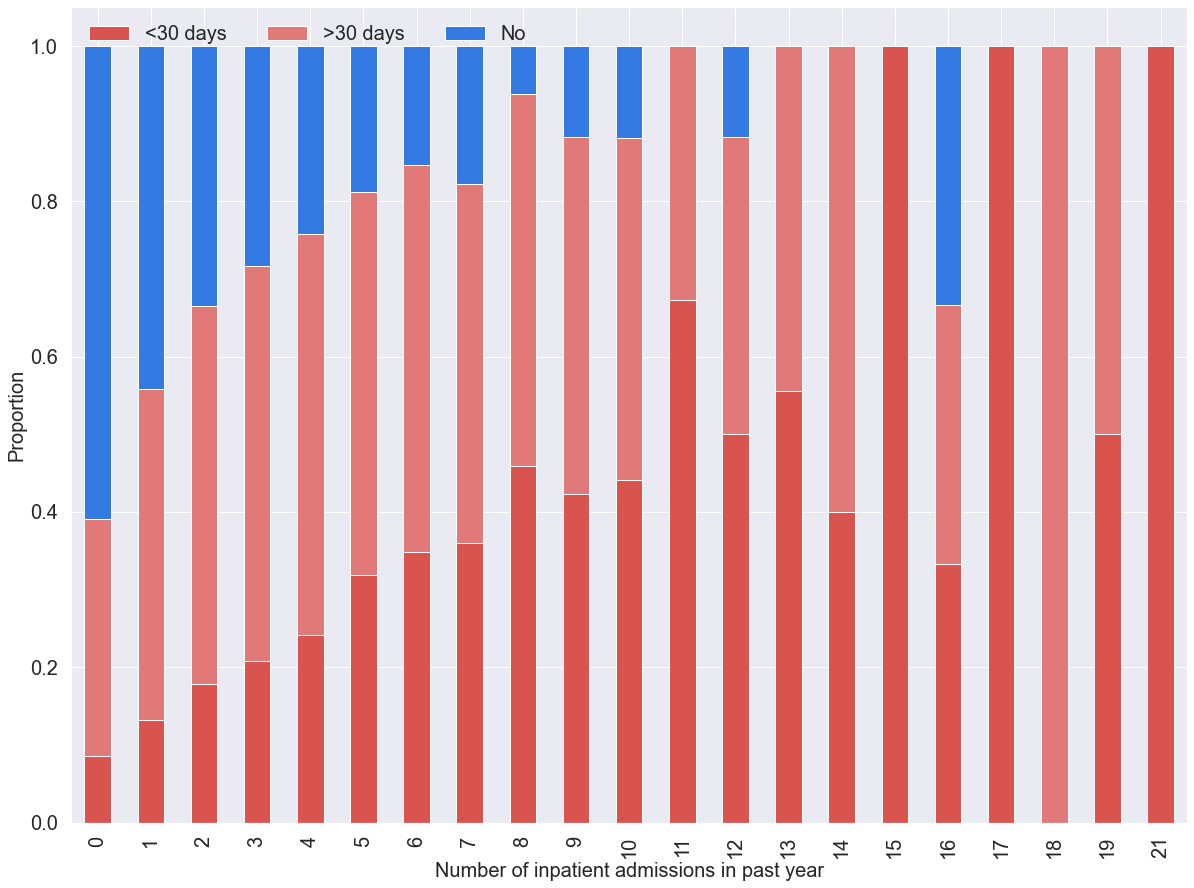

In [118]:
##Proportional table 
#https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b
cross_tab_prop = pd.crosstab(index=diab_df['number_inpatient'],
                             columns=diab_df['readmitted'],
                             normalize='index')
plt.figure(figsize=(25, 18))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    color=['#d9534f','#E17979', '#337AE3'],
                    figsize=(20, 15))

plt.legend(["<30 days",">30 days", "No"], loc="upper left", ncol=3, fontsize=20)
plt.xlabel("Number of inpatient admissions in past year", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("BMI_diabetes_stacked_bar_graph_number_inpatient_admissions.jpg", dpi=400)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1800x1296 with 0 Axes>

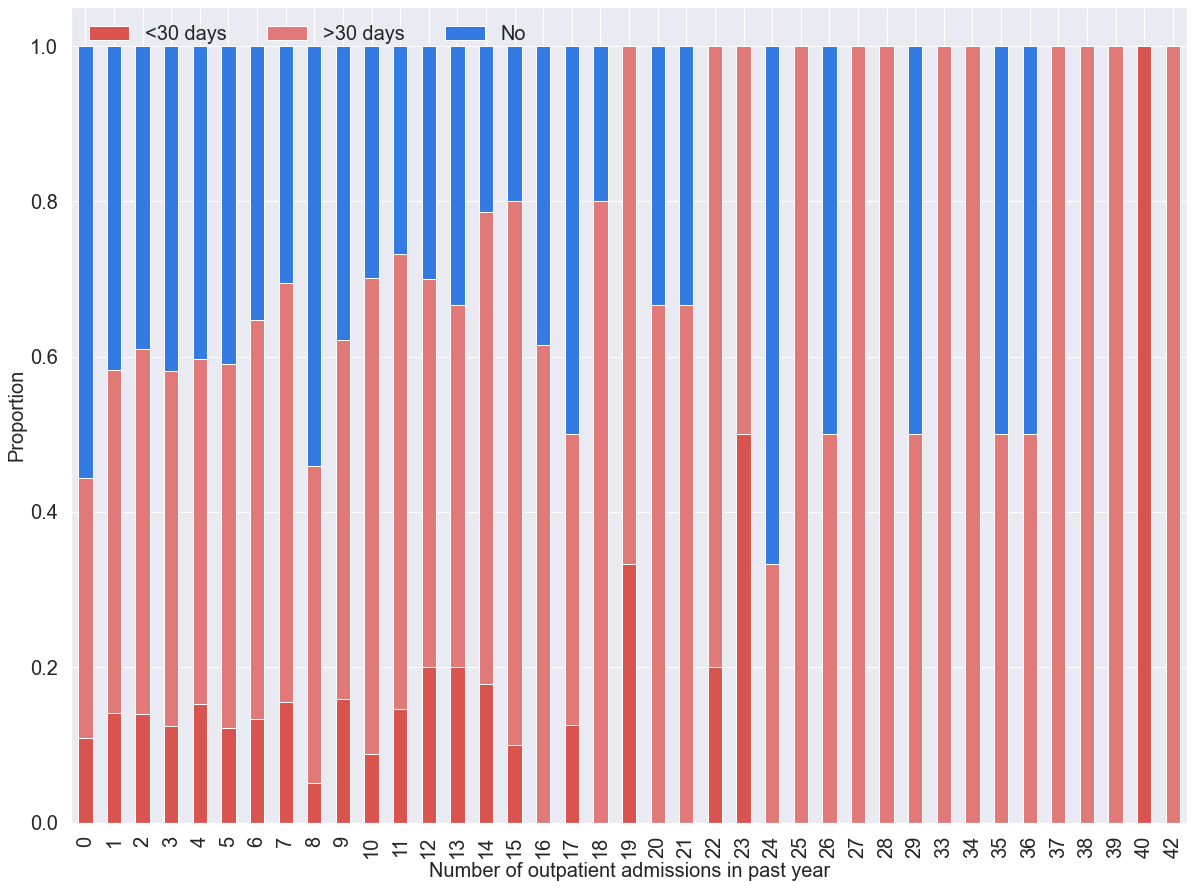

In [119]:
##Proportional table 
#https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b
cross_tab_prop = pd.crosstab(index=diab_df['number_outpatient'],
                             columns=diab_df['readmitted'],
                             normalize='index')
plt.figure(figsize=(25, 18))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    color=['#d9534f','#E17979', '#337AE3'],
                    figsize=(20, 15))

plt.legend(["<30 days",">30 days", "No"], loc="upper left", ncol=3, fontsize=20)
plt.xlabel("Number of outpatient admissions in past year", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig("BMI_diabetes_stacked_bar_graph.jpg", dpi=400)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1800x1296 with 0 Axes>

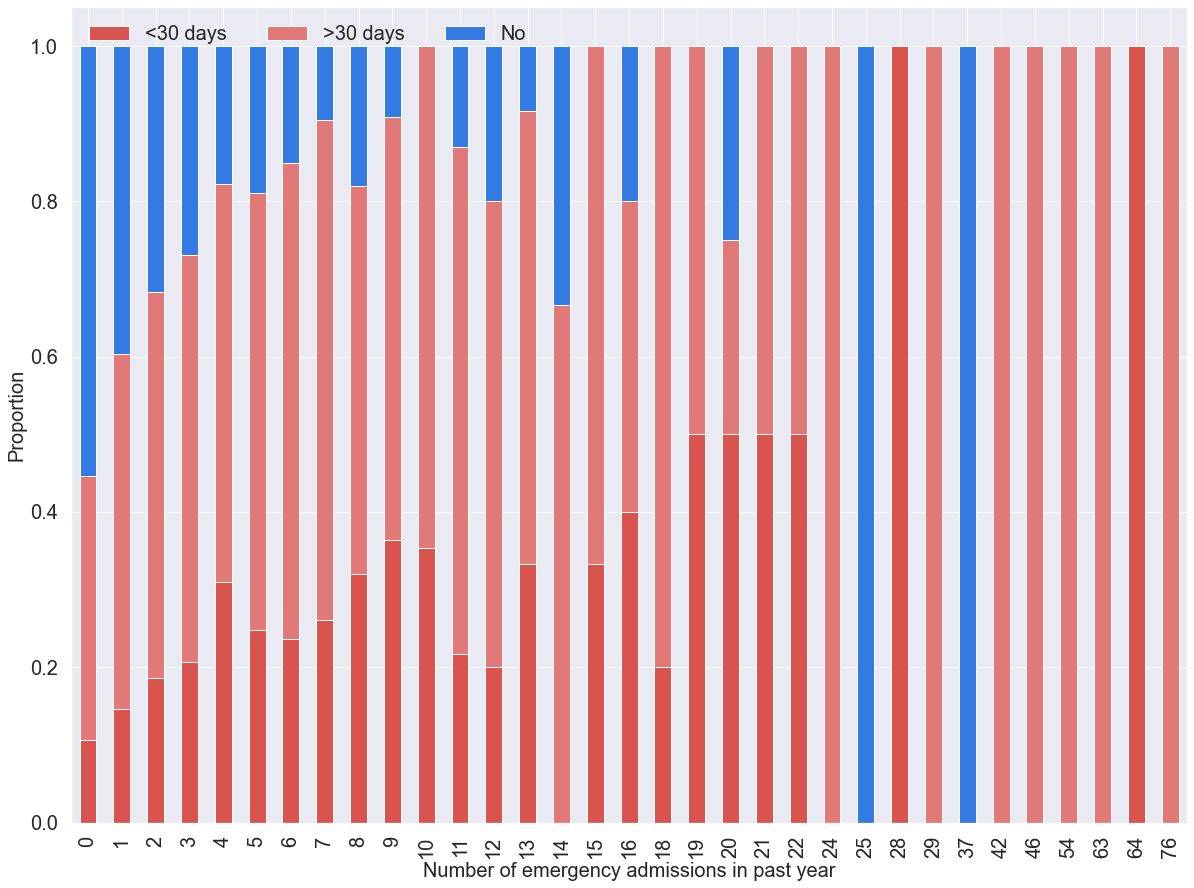

In [120]:
##Proportional table 
#https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b
cross_tab_prop = pd.crosstab(index=diab_df['number_emergency'],
                             columns=diab_df['readmitted'],
                             normalize='index')
plt.figure(figsize=(25, 18))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    color=['#d9534f','#E17979', '#337AE3'],
                    figsize=(20, 15))

plt.legend(["<30 days",">30 days", "No"], loc="upper left", ncol=3, fontsize=20)
plt.xlabel("Number of emergency admissions in past year", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig("BMI_diabetes_stacked_bar_graph.jpg", dpi=400)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1800x1296 with 0 Axes>

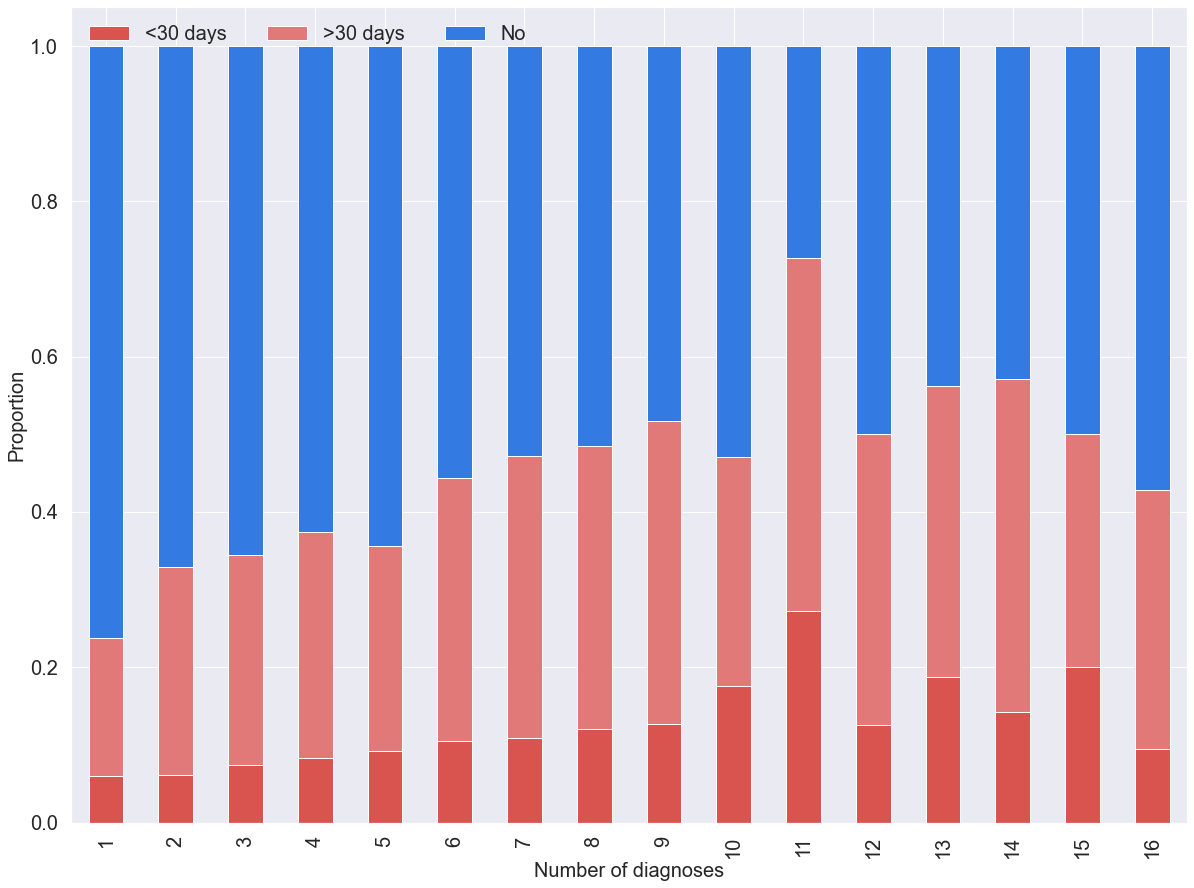

In [121]:
##Proportional table 
#https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b
cross_tab_prop = pd.crosstab(index=diab_df['number_diagnoses'],
                             columns=diab_df['readmitted'],
                             normalize='index')
plt.figure(figsize=(25, 18))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    color=['#d9534f','#E17979', '#337AE3'],
                    figsize=(20, 15))

plt.legend(["<30 days",">30 days", "No"], loc="upper left", ncol=3, fontsize=20)
plt.xlabel("Number of diagnoses", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig("BMI_diabetes_stacked_bar_graph.jpg", dpi=400)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1800x1296 with 0 Axes>

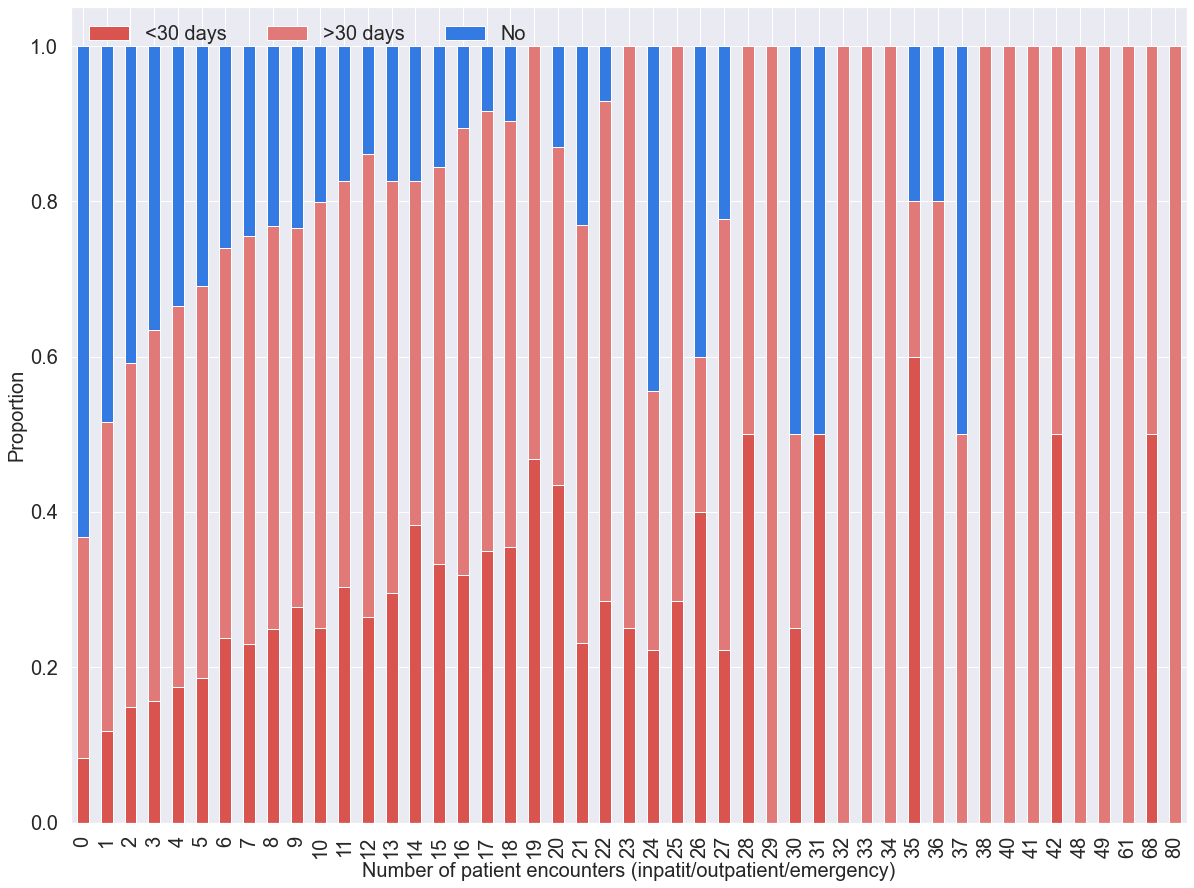

In [122]:
##Proportional table 
#https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b
cross_tab_prop = pd.crosstab(index=diab_df['hosp_encounters_year'],
                             columns=diab_df['readmitted'],
                             normalize='index')
plt.figure(figsize=(25, 18))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    color=['#d9534f','#E17979', '#337AE3'],
                    figsize=(20, 15))

plt.legend(["<30 days",">30 days", "No"], loc="upper left", ncol=3, fontsize=20)
plt.xlabel("Number of patient encounters (inpatit/outpatient/emergency)", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig("BMI_diabetes_stacked_bar_graph.jpg", dpi=400)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1800x1296 with 0 Axes>

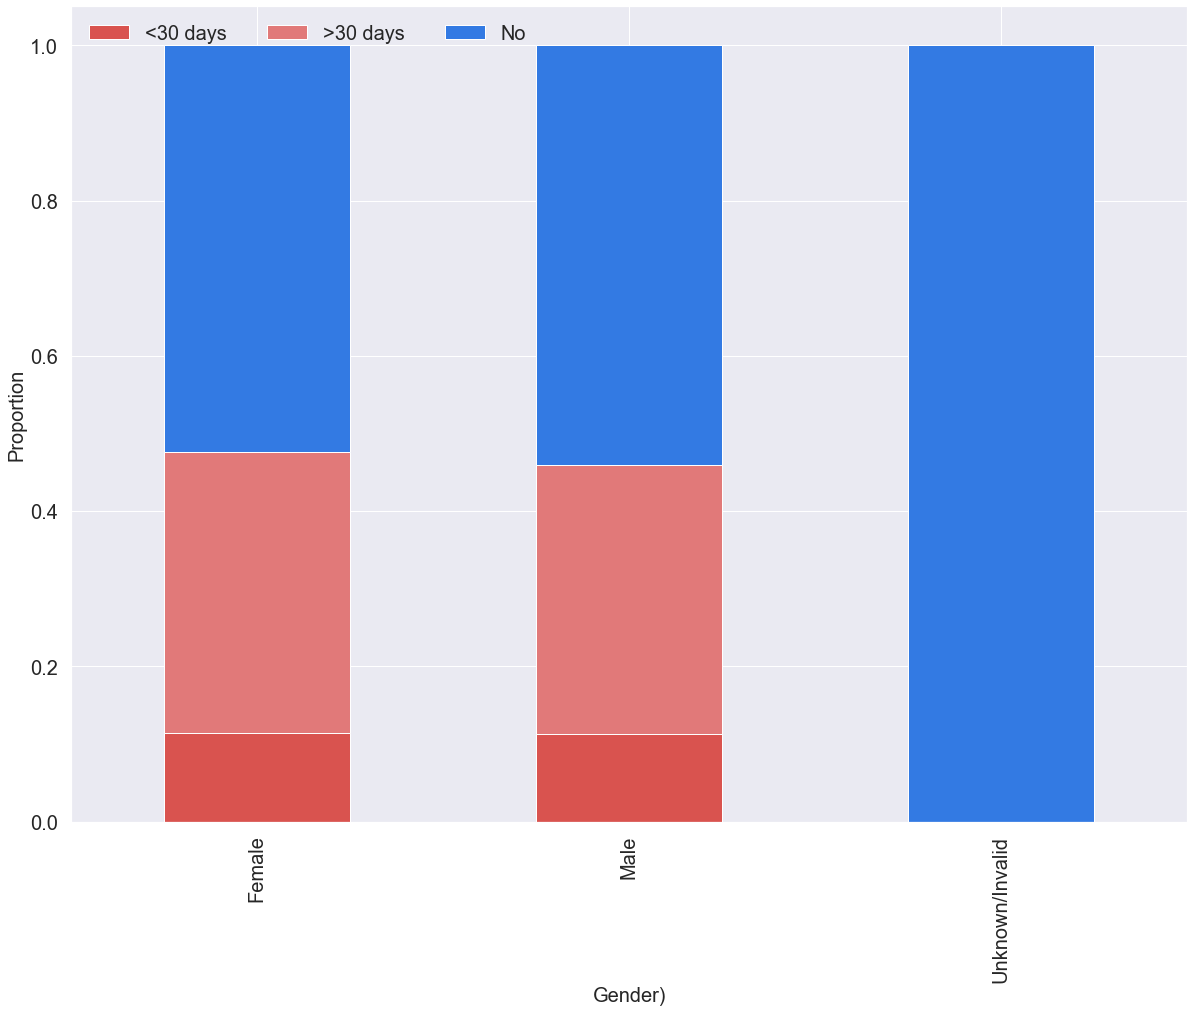

In [123]:
##Proportional table 
#https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b
cross_tab_prop = pd.crosstab(index=diab_df['gender'],
                             columns=diab_df['readmitted'],
                             normalize='index')
plt.figure(figsize=(25, 18))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    color=['#d9534f','#E17979', '#337AE3'],
                    figsize=(20, 15))

plt.legend(["<30 days",">30 days", "No"], loc="upper left", ncol=3, fontsize=20)
plt.xlabel("Gender)", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig("BMI_diabetes_stacked_bar_graph.jpg", dpi=400)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1800x1296 with 0 Axes>

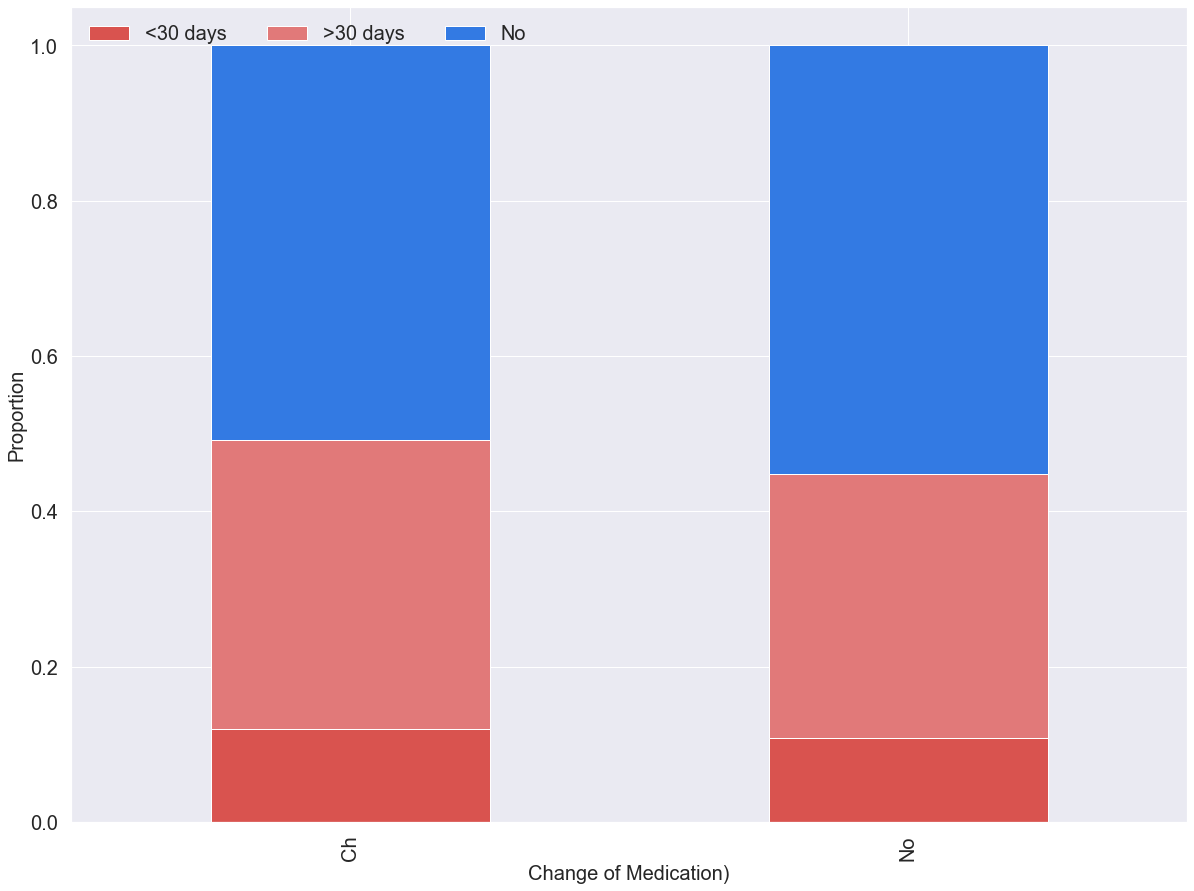

In [124]:
##Proportional table 
#https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b
cross_tab_prop = pd.crosstab(index=diab_df['change'],
                             columns=diab_df['readmitted'],
                             normalize='index')
plt.figure(figsize=(25, 18))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    color=['#d9534f','#E17979', '#337AE3'],
                    figsize=(20, 15))

plt.legend(["<30 days",">30 days", "No"], loc="upper left", ncol=3, fontsize=20)
plt.xlabel("Change of Medication)", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig("BMI_diabetes_stacked_bar_graph.jpg", dpi=400)

## Modelling

### Logistic Regression

In [125]:
from sklearn import linear_model
logit_1 = linear_model.LogisticRegression()

In [126]:
logit_1.fit(df.iloc[:, :-1], df["readmitted"])

ValueError: could not convert string to float: 'Caucasian'

In [ ]:
## Modeling 

In [ ]:
#### PCA 

In [ ]:
#### Logistic Regression 

In [ ]:
#### XG boost